In [194]:
from sklearn.model_selection import cross_val_score, cross_validate

In [174]:
import itertools
import re

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline
sns.set(style="ticks")

# Для лучшего качествоа графиков
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# Устанавливаем ширину экрана для отчета
pd.set_option("display.width", 70)

# Загружаем данные
data = pd.read_csv('steam.csv')
data.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


### Исследуем набор данных

In [100]:
data.isnull().sum()

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

Пропусков нет 

In [71]:
data.shape

(27075, 18)

In [72]:
data.describe()

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,2.707500e+04,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000
mean,5.962035e+05,0.981127,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,6.078193
std,2.508942e+05,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,7.874922
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,4.012300e+05,1.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.690000
50%,5.990700e+05,1.000000,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,3.990000
75%,7.987600e+05,1.000000,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,7.190000
max,1.069460e+06,1.000000,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,421.990000


In [14]:
data.dtypes

appid                 int64
name                 object
release_date         object
english               int64
developer            object
publisher            object
platforms            object
required_age          int64
categories           object
genres               object
steamspy_tags        object
achievements          int64
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
median_playtime       int64
owners               object
price               float64
dtype: object

Но сначала сделаем, кодирование категориальных признаков. genre, developer 

In [73]:
data['genres'].value_counts()

Action;Indie                                                          1852
Casual;Indie                                                          1482
Action;Adventure;Indie                                                1229
Adventure;Indie                                                       1170
Action;Casual;Indie                                                   1004
                                                                      ... 
Violent;Gore;Adventure;Casual;RPG                                        1
Casual;Free to Play;Indie;Racing;Sports                                  1
Sexual Content;Nudity;Action                                             1
Animation & Modeling;Design & Illustration;Photo Editing;Utilities       1
Indie;Massively Multiplayer;RPG;Strategy;Early Access                    1
Name: genres, Length: 1552, dtype: int64

In [175]:
def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    cat_cols = get_unique(df['categories'])
    
    cat_cols = [
        'Multi-player',
        'Single-player'
    ]
    
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_cols = get_unique(df['genres'])
    
    gen_cols = [
        'Action',
        'Adventure',
        'Casual',
        'Free to Play',
        'Indie',
        'Massively Multiplayer',
        'RPG',
        'Racing',
        'Sexual Content',
        'Simulation',
        'Sports',
        'Strategy'
        'Violent',
    ]
    
    gen_col_names = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0]
        
    tag_cols = get_unique(df['steamspy_tags'])
    
    df = df.drop(['categories', 'genres', 'steamspy_tags'], axis=1)
    
    return df

# Среднее количнство владельцев
data['owners'] = data['owners'].str.split('-').apply(lambda x: (int(x[0]) + int(x[1])) / 2).astype(int)
data = process_cat_gen_tag(data)

In [176]:
le1 = LabelEncoder()
data['developer'] = le1.fit_transform(data['developer']);

In [177]:
le2 = LabelEncoder()
data['name'] = le2.fit_transform(data['name']);

In [178]:
data['owners'].value_counts()

10000        18199
35000         2965
75000         1629
150000        1336
350000        1231
750000         482
1500000        263
3500000        183
7500000         43
15000000        21
35000000         3
75000000         2
150000000        1
Name: owners, dtype: int64

In [179]:
data.dtypes

appid                      int64
name                       int64
release_date              object
english                    int64
developer                  int64
publisher                 object
platforms                 object
required_age               int64
achievements               int64
positive_ratings           int64
negative_ratings           int64
average_playtime           int64
median_playtime            int64
owners                     int64
price                    float64
multi_player               int64
single_player              int64
action                     int64
adventure                  int64
casual                     int64
free_to_play               int64
indie                      int64
massively_multiplayer      int64
rpg                        int64
racing                     int64
sexual_content             int64
simulation                 int64
sports                     int64
strategyviolent            int64
dtype: object

In [180]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

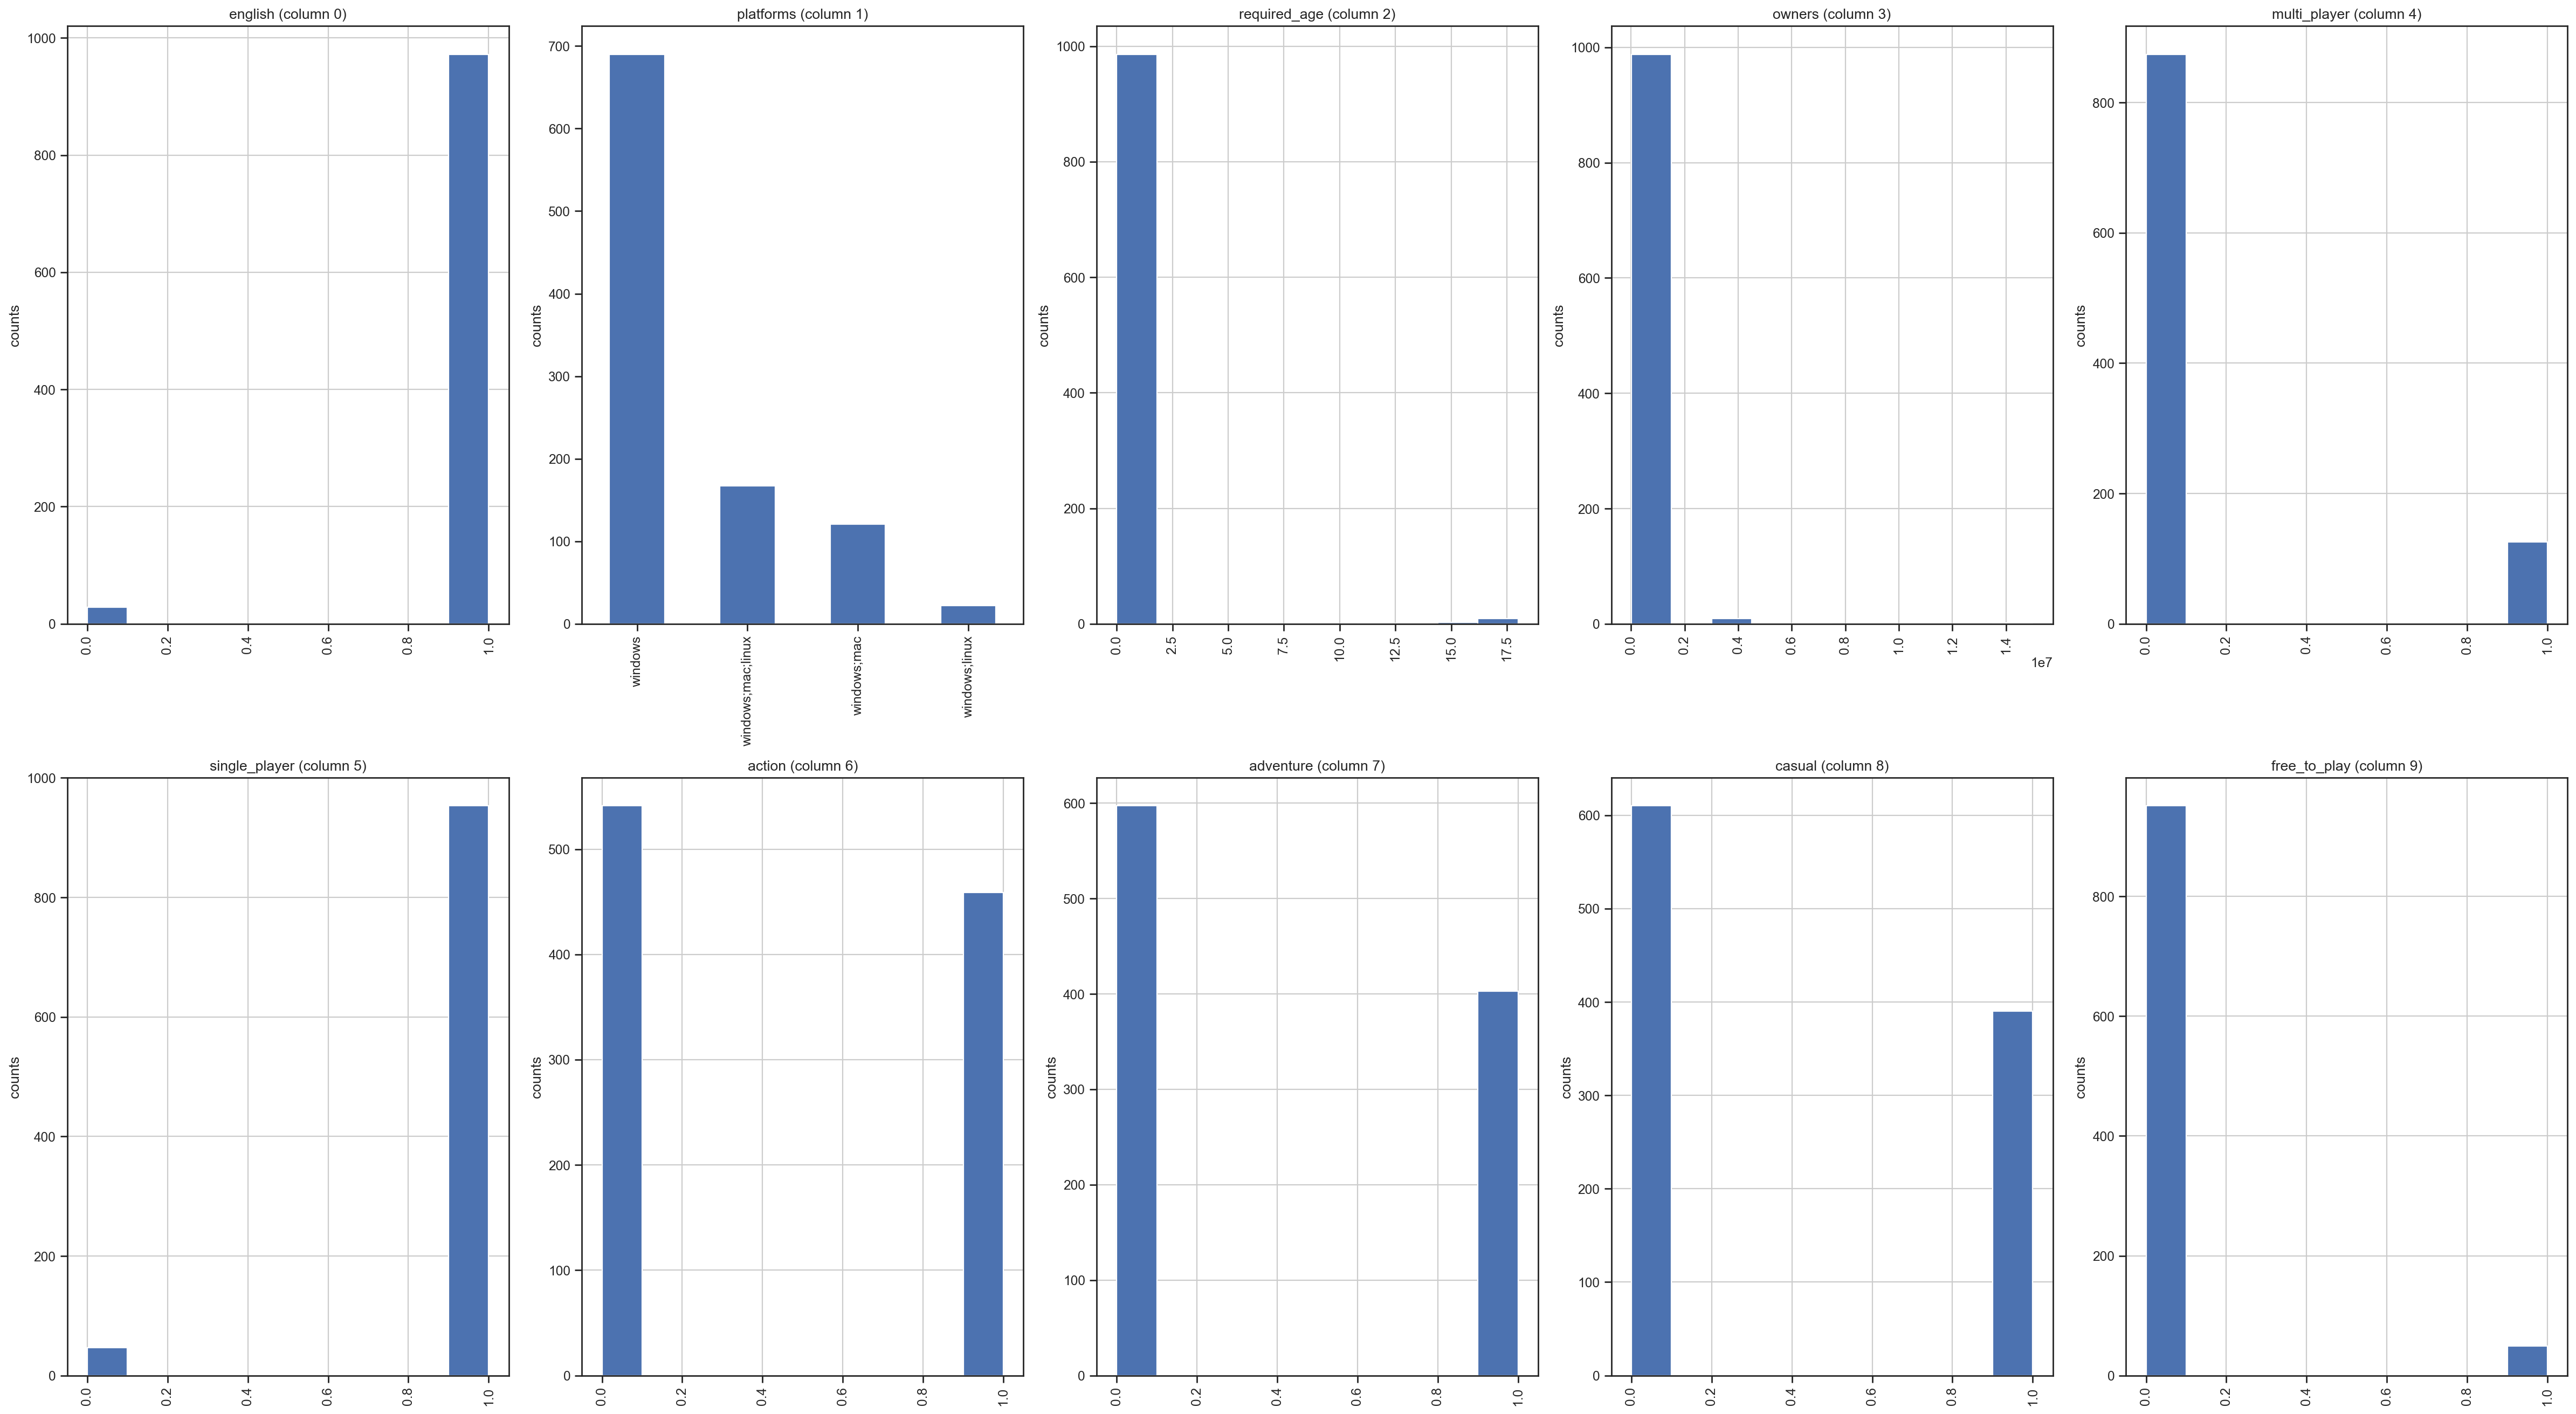

In [145]:
dfsample = data.sample(1000)
dfsample.dataframeName = 'steam'
plotPerColumnDistribution(dfsample, 10, 5)

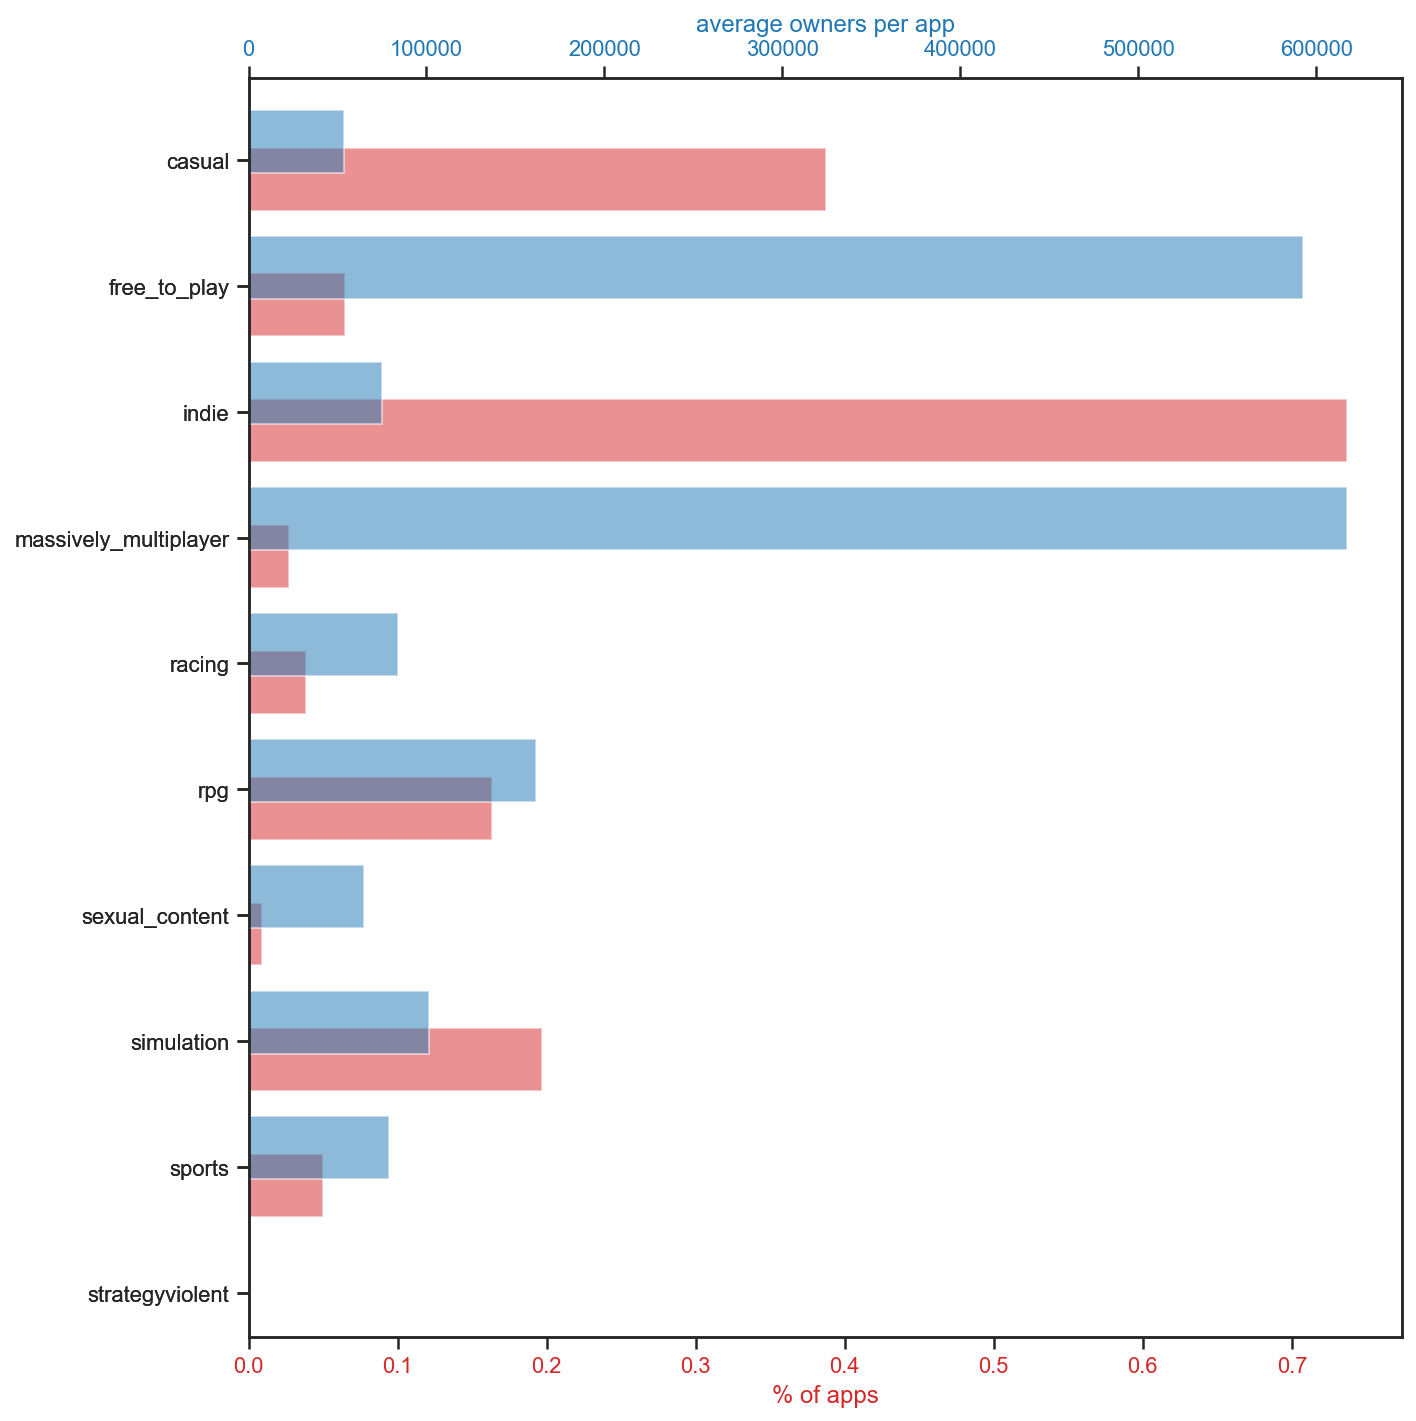

In [127]:
genre_cols = data.columns[-10:]

total_owners_per_genre = data[genre_cols].multiply(data['owners'], axis='index').sum()
average_owners_per_genre = total_owners_per_genre / data[genre_cols].sum()

fig, ax1 = plt.subplots()

color = 'tab:red'
data[genre_cols].mean().sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.5, position=.8)

ax1.set_xlabel('% of apps', color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()

color = 'tab:blue'
average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=.5, position=.2, label='1', figsize=[10, 10])
ax2.set_xlabel('average owners per app', color=color)
ax2.tick_params(axis='x', labelcolor=color)

plt.tight_layout()
plt.show()

Можем видеть, что по количеству игроков преобладает 2 жанра:
    - Free-to-Play
    - Massive Multiplayer
    
А по количеству игр:
    - Indie
    - Casual

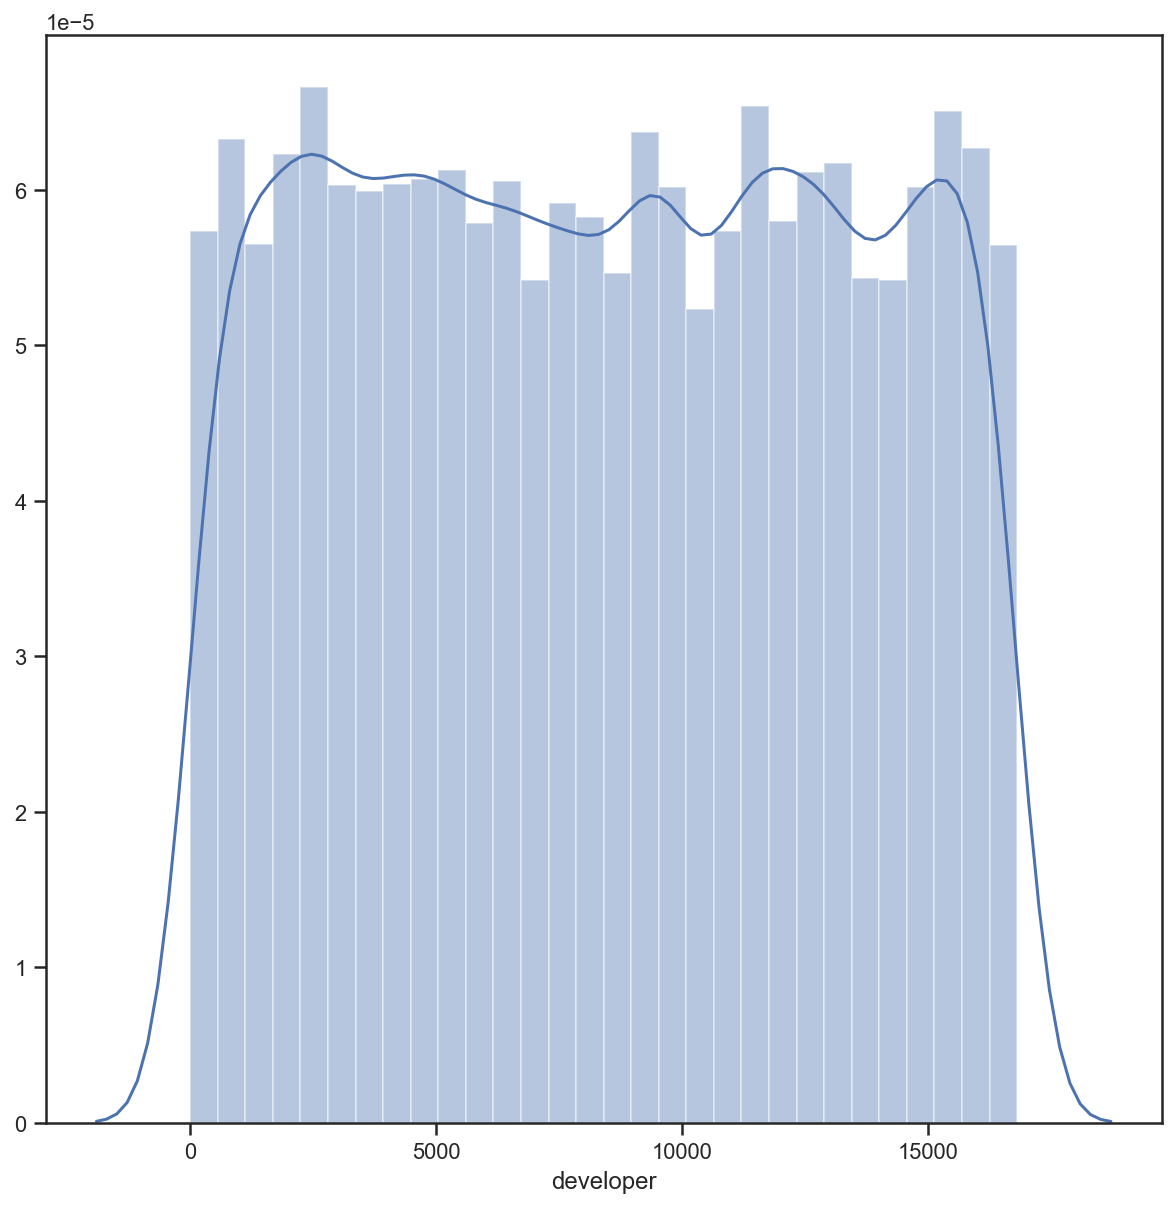

In [146]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(data['developer'])

По гистограмме можно сказать, что у разработчиков примерно одинаковое количество игр.

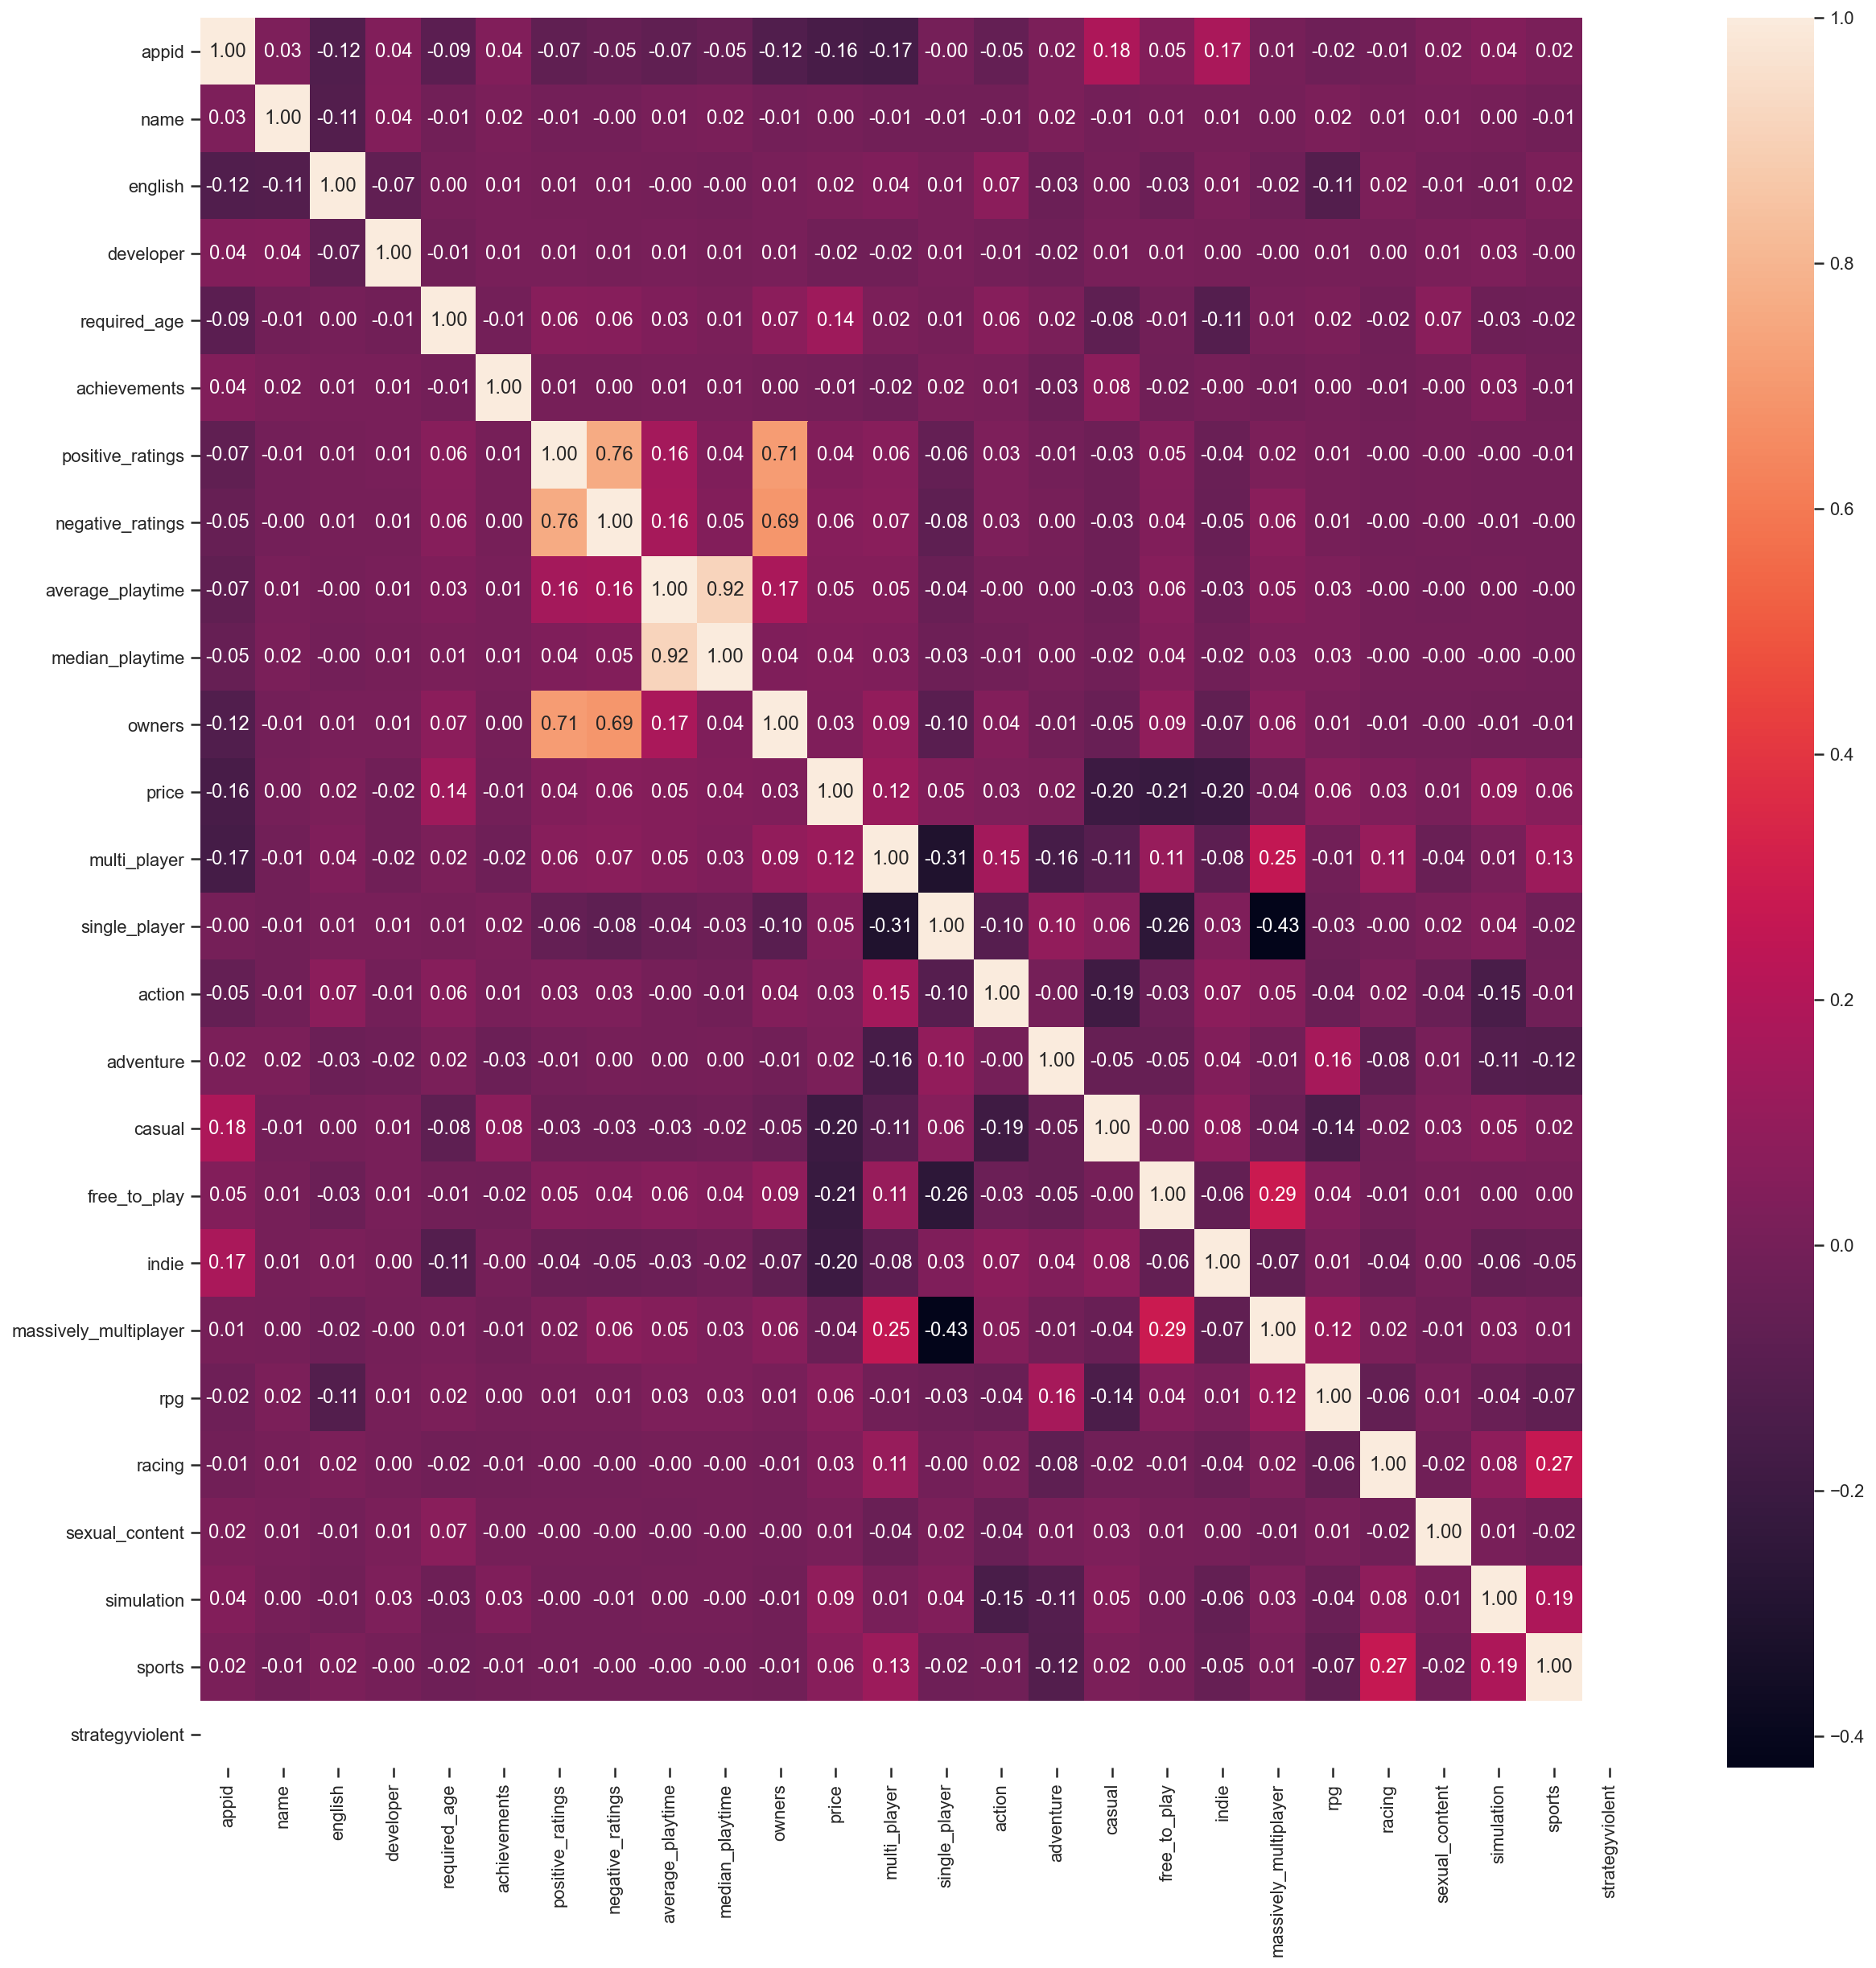

In [147]:
plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, fmt='.2f')

Можем увидеть что есть корреляция между:

    - Price и Required Age завист друг от друга
    - Среднее время игровой сессии завсит от оценок(positive/negative ratings)
    - Количесто игроков зависит от отзывов (positive/negative ratings)
    - Прямая корреляция между 2 жанрами: MMO и Free-To-Play

Наш целевой признак multi_player:
    - Убирем не коллериющуие признаки: appid, developer, achivments, single_player, adventure 

### Метрики

In [153]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [154]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

### Формирование обучающей и тестовой выборки

In [160]:
data.columns

Index(['appid', 'name', 'release_date', 'english', 'developer',
       'publisher', 'platforms', 'required_age', 'achievements',
       'positive_ratings', 'negative_ratings', 'average_playtime',
       'median_playtime', 'owners', 'price', 'multi_player',
       'single_player', 'action', 'adventure', 'casual',
       'free_to_play', 'indie', 'massively_multiplayer', 'rpg',
       'racing', 'sexual_content', 'simulation', 'sports',
       'strategyviolent'],
      dtype='object')

In [161]:
class_cols = ['english', 'required_age',
       'positive_ratings', 'negative_ratings', 'average_playtime',
       'median_playtime', 'owners', 'price', 'action', 'casual',
       'free_to_play', 'indie', 'massively_multiplayer', 'rpg',
       'racing', 'sexual_content', 'simulation', 'sports',
       'strategyviolent']

In [162]:
X = data[class_cols]
y = data['multi_player']

X.shape

(26358, 19)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [172]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_test:", Y_test.shape)

X_train: (19768, 19)
X_test: (6590, 19)
Y_train: (19768,)
Y_test: (6590,)


### Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров

In [165]:
models = {'KNN_3':KNeighborsClassifier(n_neighbors=3),
          'SVC':SVC(),
          'Tree':DecisionTreeClassifier(),
          'RF':RandomForestClassifier(),
          'GB':GradientBoostingClassifier()}

In [166]:
metricLogger = MetricLogger()

In [184]:
def test_model(model_name, model, metricLogger):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    metricLogger.add('precision', model_name, precision)
    metricLogger.add('recall', model_name, recall)
    metricLogger.add('accuracy', model_name, accuracy)
    metricLogger.add('roc_auc', model_name, roc_auc)
    
    print('*****************************************************')
    print(model)
    print("accuracy:", accuracy)
    print("recall:", recall)
    print("precision:", precision)
    print("roc_auc:", roc_auc)
    print('*****************************************************')
    draw_roc_curve(y_test, y_pred)
    
    plot_confusion_matrix(model, X_test, y_test, 
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    plt.show()

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
accuracy: 0.8251896813353566
recall: 0.1446673706441394
precision: 0.2860125260960334
roc_auc: 0.5420306550190395
*****************************************************


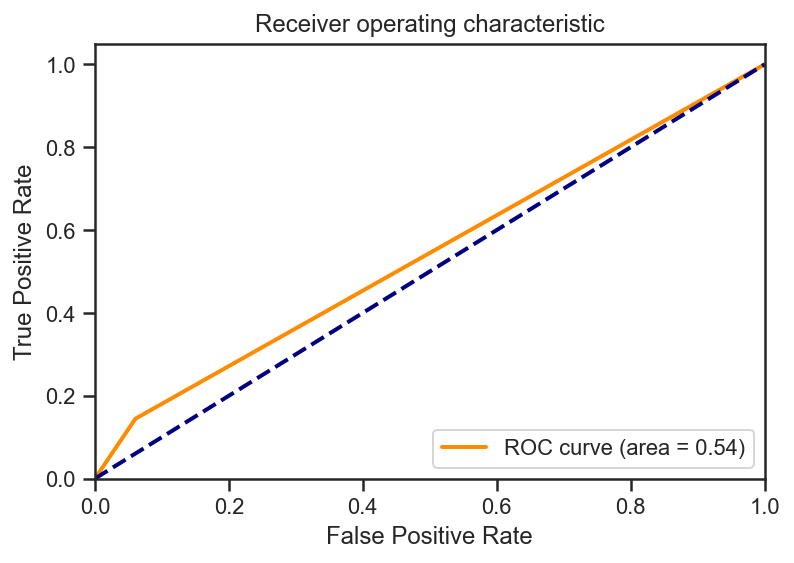

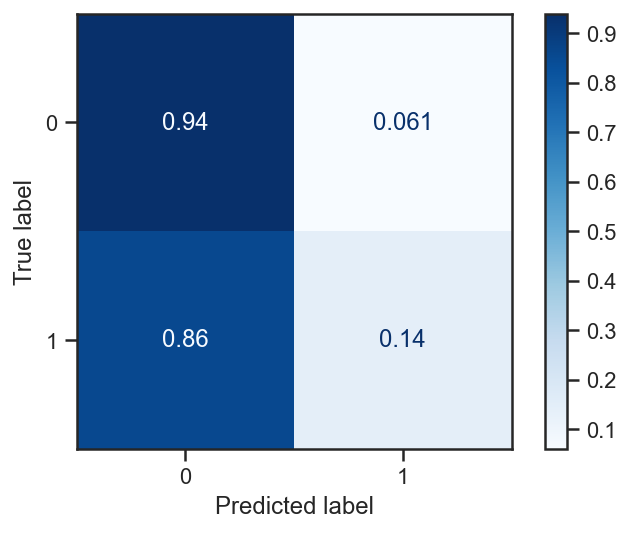

*****************************************************
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
accuracy: 0.8569044006069803
recall: 0.009503695881731784
precision: 0.6428571428571429
roc_auc: 0.5043088211820497
*****************************************************


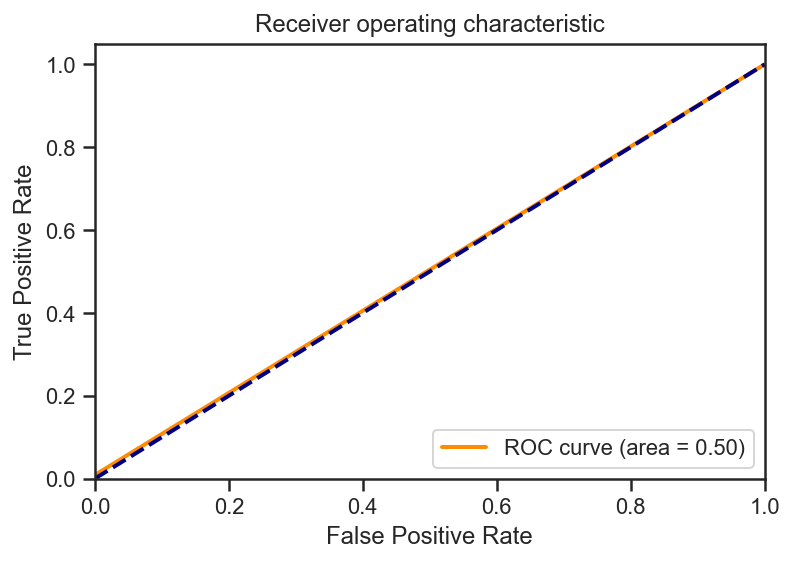

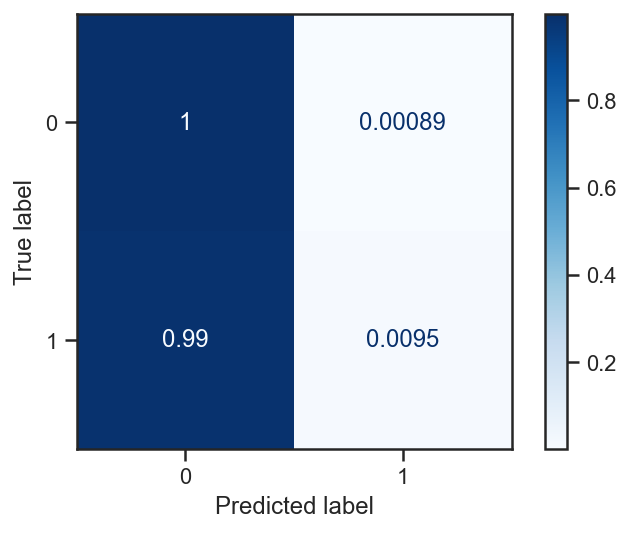

*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
accuracy: 0.796206373292868
recall: 0.31784582893347413
precision: 0.3016032064128257
roc_auc: 0.5971649842877542
*****************************************************


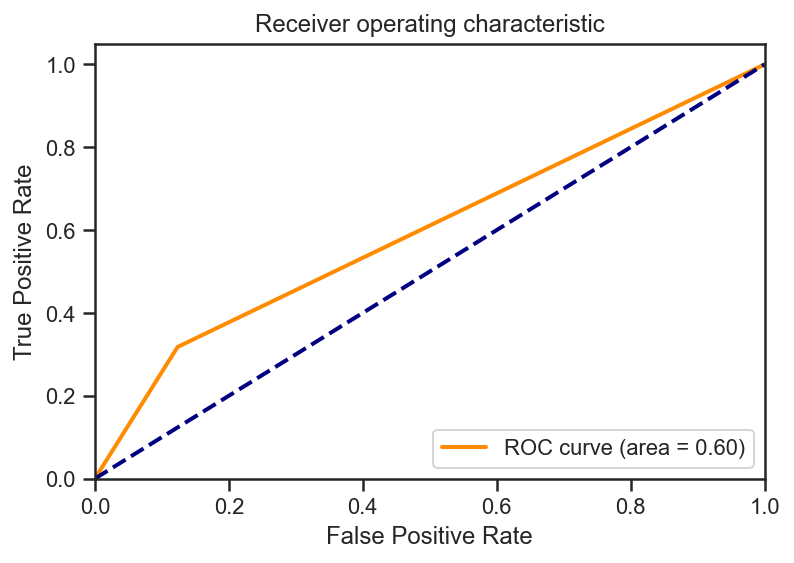

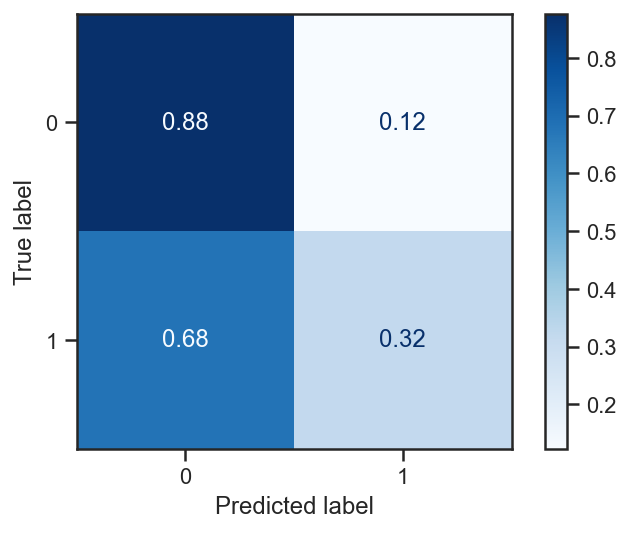

*****************************************************
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
accuracy: 0.8575113808801214
recall: 0.22280887011615627
precision: 0.5096618357487923
roc_auc: 0.5934175486501391
*****************************************************


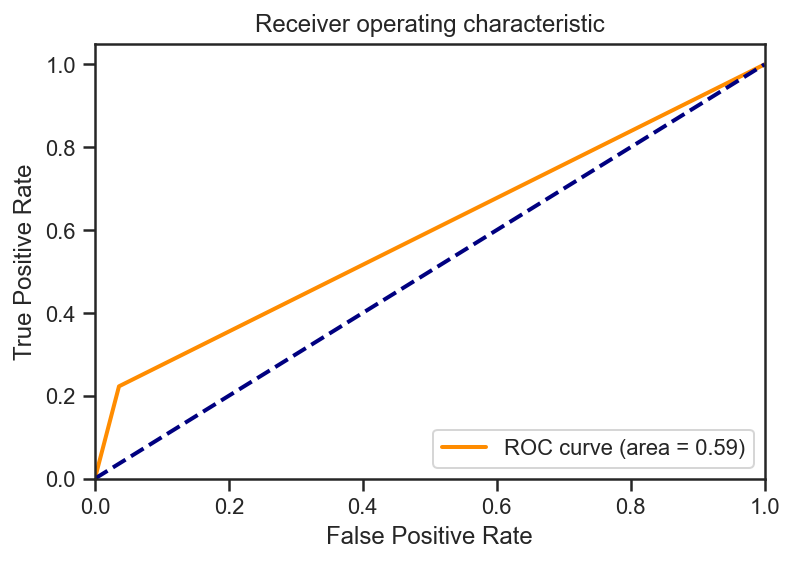

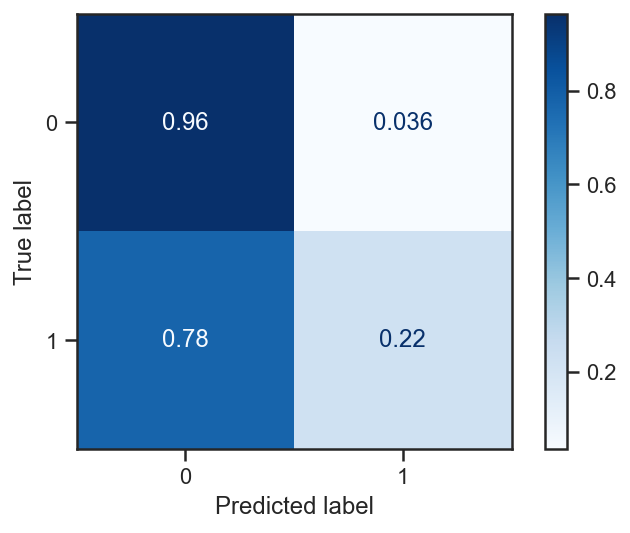

*****************************************************
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
accuracy: 0.870257966616085
recall: 0.20274551214361142
precision: 0.6575342465753424
roc_auc: 0.5925122208954811
*****************************************************


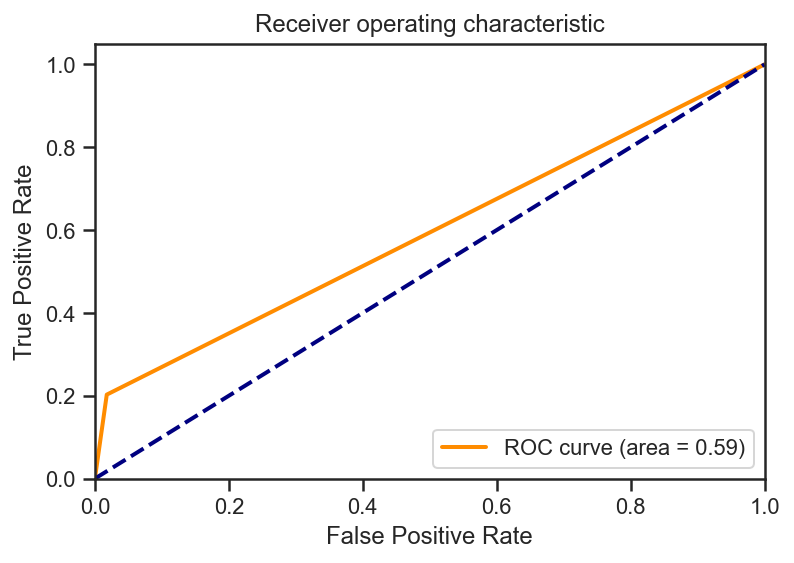

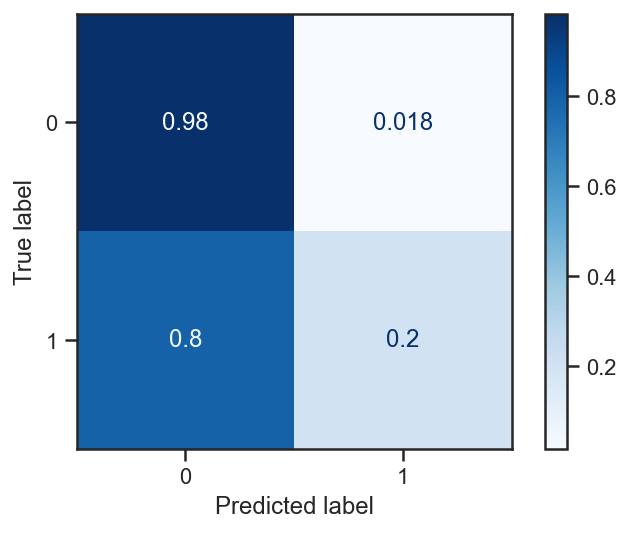

In [185]:
for model_name, model in models.items():
    test_model(model_name, model, metricLogger)

### Подбор гиперпараметров

In [187]:
n_range = np.array(range(0,30,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}]

In [206]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy', n_jobs = -1)
clf_gs.fit(X, y)

CPU times: user 1.42 s, sys: 187 ms, total: 1.61 s
Wall time: 46.4 s


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [207]:
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=28, p=2,
                     weights='uniform')

In [208]:
clf_gs.best_params_

{'n_neighbors': 28}

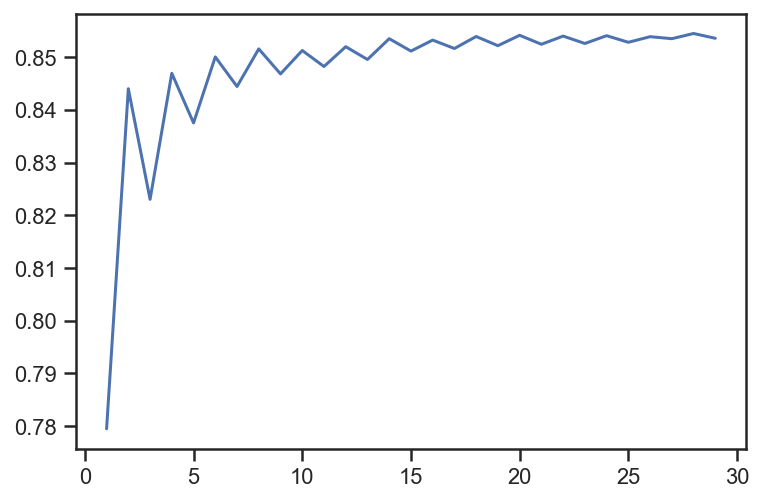

In [209]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [218]:
tree_param = {'criterion':['gini','entropy'], 'splitter': ['best', 'random'], 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150, 1000]}

clf_gs = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5)
clf_gs.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [219]:
clf_gs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [220]:
clf_gs.best_params_

{'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}

In [ ]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
}

clf_gs = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)
clf_gs.fit(X, y)

In [ ]:
clf_gs.best_estimator_

In [227]:
clf_gs.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'splitter': 'random'}

### Сравнение качества полученных моделей с качеством baseline-моделей.

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=28, p=2,
                     weights='uniform')
accuracy: 0.8599393019726859
recall: 0.06335797254487856
precision: 0.625
roc_auc: 0.5284891936089624
*****************************************************


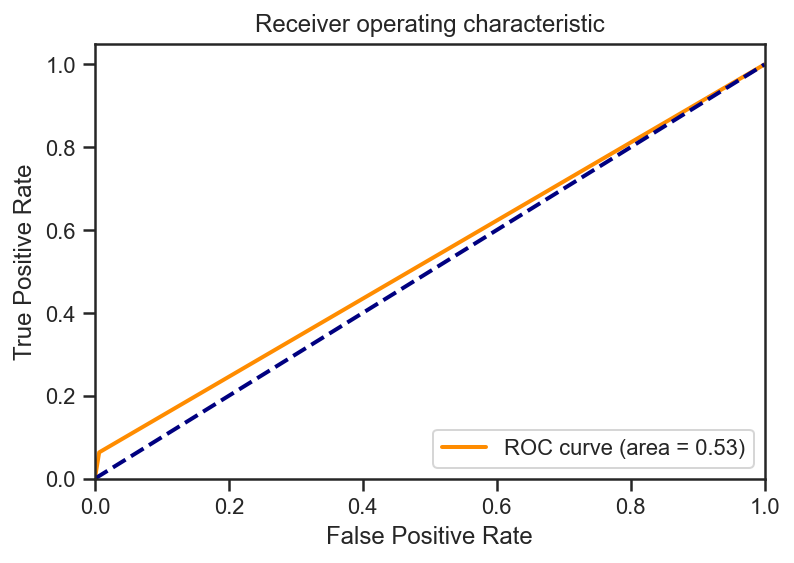

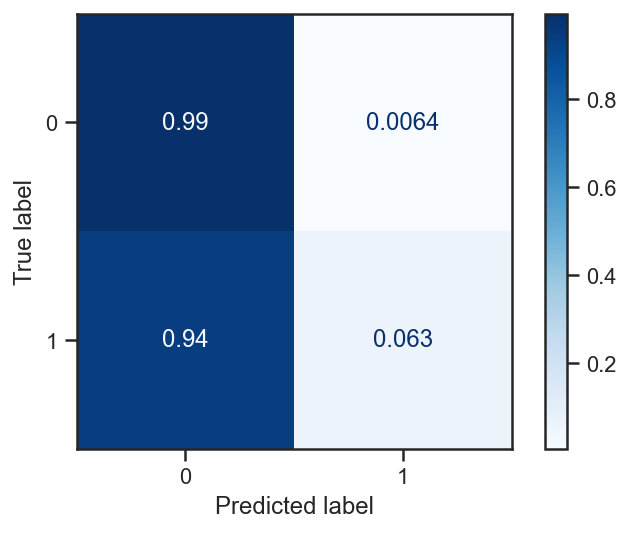

In [192]:
test_model('KNN_5', KNeighborsClassifier(n_neighbors=28), metricLogger)

*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
accuracy: 0.866464339908953
recall: 0.1457233368532207
precision: 0.6602870813397129
roc_auc: 0.5665706884514199
*****************************************************


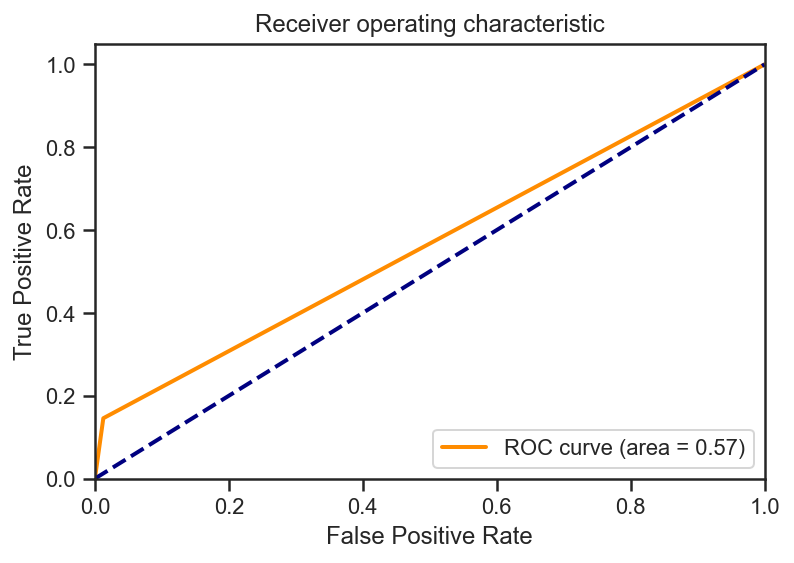

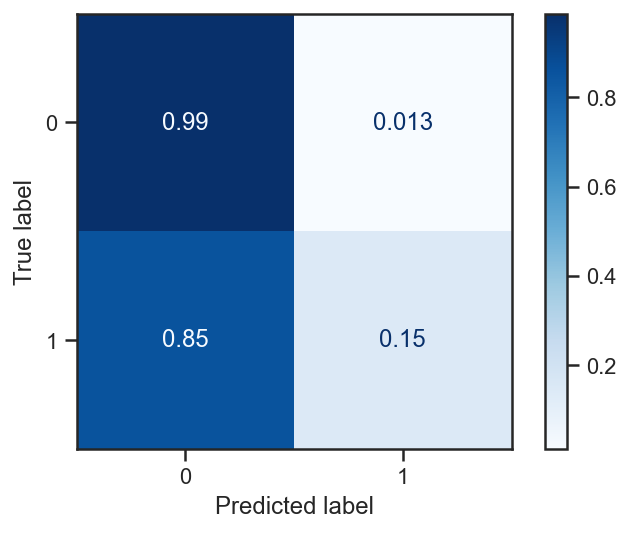

In [216]:
test_model('Tree_4', DecisionTreeClassifier(criterion='gini', max_depth=4), metricLogger)

*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
accuracy: 0.8670713201820941
recall: 0.18796198521647306
precision: 0.624561403508772
roc_auc: 0.5845002199695692
*****************************************************


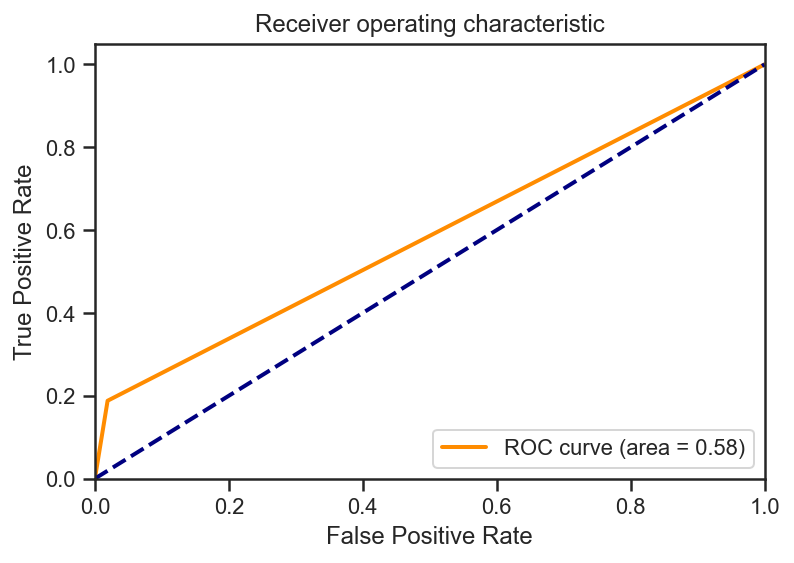

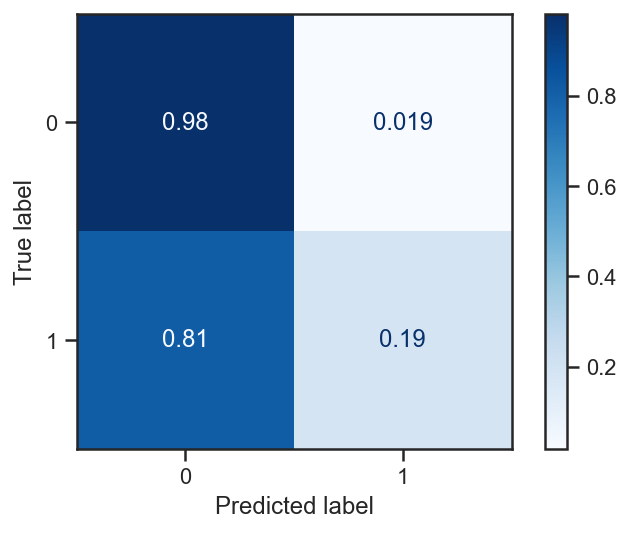

In [228]:
test_model('Tree_7', DecisionTreeClassifier(criterion='gini', max_depth=7, splitter='best'), metricLogger)

### Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. 

In [229]:
metrics = metricLogger.df['metric'].unique()
metrics

array(['precision', 'recall', 'accuracy', 'roc_auc'], dtype=object)

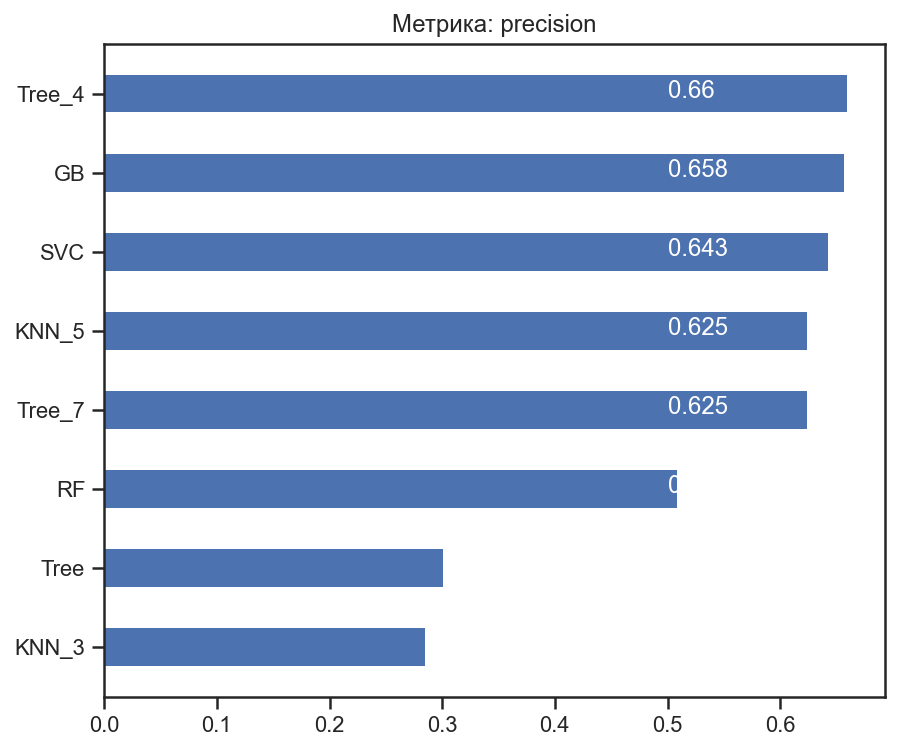

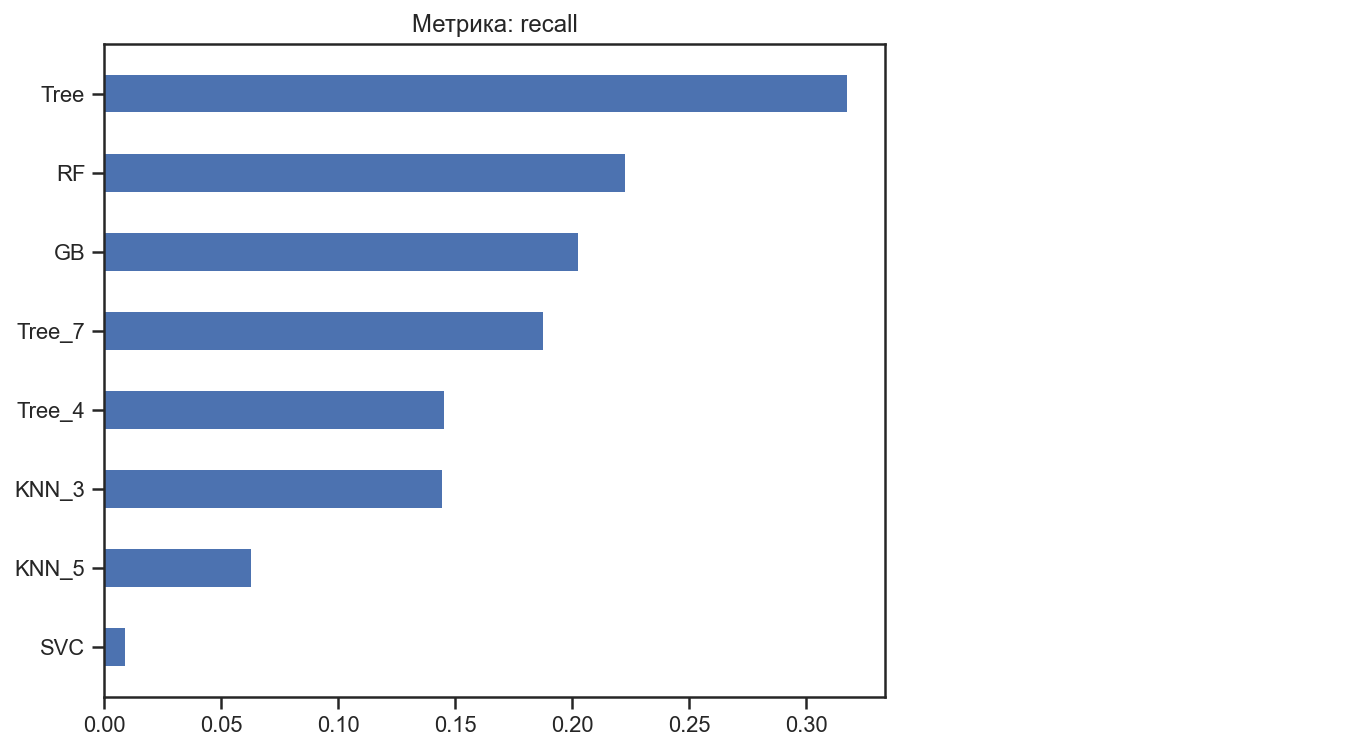

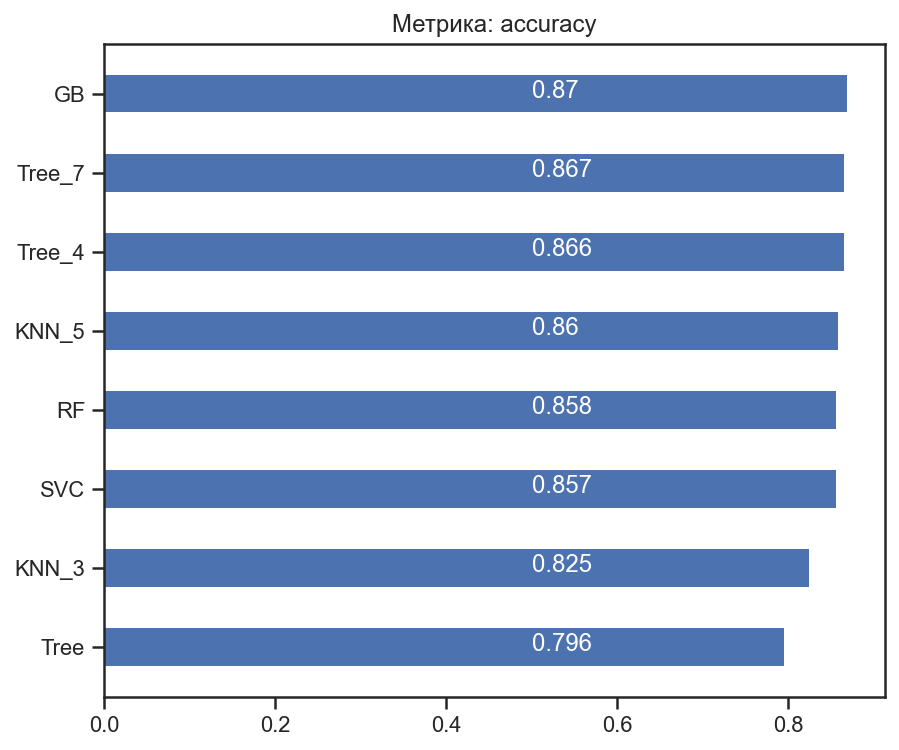

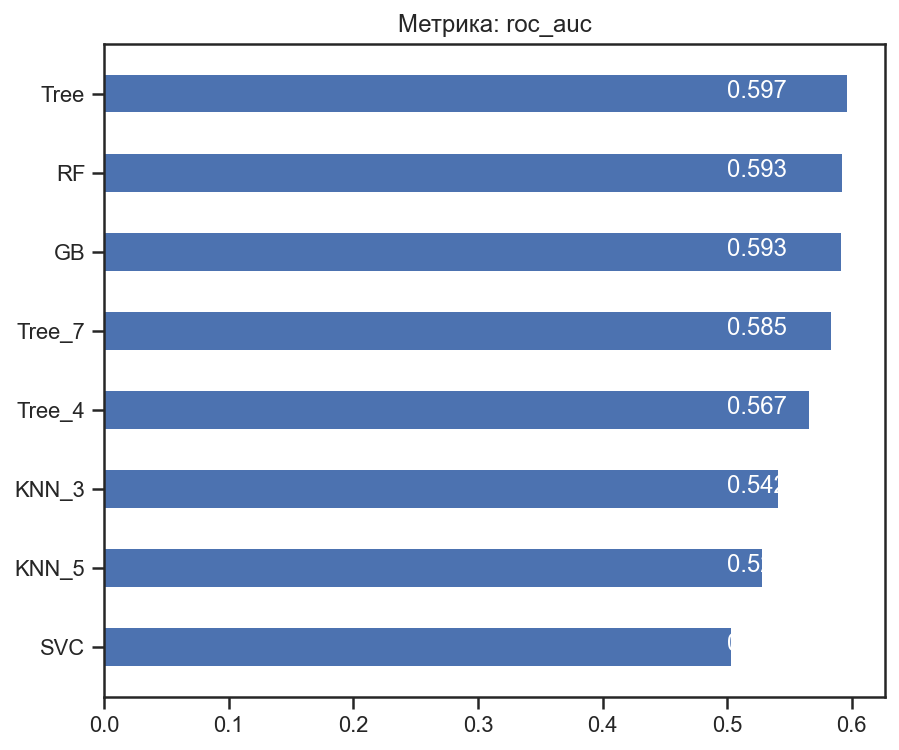

In [230]:
for metric in metrics:
    metricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))